In [22]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import pandas as pd
import numpy as np
import re

import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext, HiveContext, SparkSession
from pyspark import StorageLevel

spark_context = SparkContext.getOrCreate()
sql_context = SparkSession.builder.enableHiveSupport().getOrCreate() # or sql_context = HiveContext(spark_context)

#<font color="green"> Playing around with some strings manipulation </font>

In [24]:
class FileManipulation:

  def write_text_in_file(text: str, file_name: str) -> None:

    try:
      f = open(file_name, "w")
      f.write(text)
      f.close()
    except Exception as error:
      return "ERROR: " + str(error)

  def read_file(file_name: str) -> str:

    try:
      f = open(file_name, "r")
      text = f.read()
      f.close()
    except Exception as error:
      return "ERROR: " + str(error)
    else:
      return text

my_string = """I made This EXAMPLE text mAdE
In order To BUILD a DOC-TERM matrix
By utilising Spark RDDs!
The sentences: are, separated by a newline..."""

FileManipulation.write_text_in_file(text=my_string, file_name="/content/sample_data/doc_term.txt")

In [25]:
class TextFileUtility:

  aux_increment = -1

  def __init__(self, from_file: str, sc: pyspark.SparkContext):
    
    self.__file = from_file
    self.__spark_context = sc

    self.__content_rdd = self.__spark_context.hadoopFile(path=self.__file,
                                                         inputFormatClass="org.apache.hadoop.mapred.TextInputFormat",
                                                         keyClass="org.apache.hadoop.io.LongWritable",
                                                         valueClass="org.apache.hadoop.io.Text") \
                                             .map(lambda pair: pair[1].lower())
    
    """
      -> I persist it because it's going to be used frequently

      -> Storage location in Memory or Disk if there's not enough space in memory

      -> Replication order of 2 so that it won't be necessary to start a new 
         "rebuild the partition" task if a partition on a node becomes unavailable
    """
    self.__content_rdd.persist(storageLevel=StorageLevel.MEMORY_AND_DISK_2)
  

  def get_set_of_words(self):

    reg_exp = "[ \.\?\!\,\:\;]"

    set_of_words_rdd = self.__content_rdd.flatMap(lambda text: re.split(reg_exp, text)) \
                                         .filter(lambda word: word != "") \
                                         .distinct() \
                                         .sortBy(lambda word: word)
    
    return set_of_words_rdd.collect()
  

  def increment_function():

    TextFileUtility.aux_increment += 1
    
    return TextFileUtility.aux_increment


  def word_count_per_sample(self):

    reg_exp = "[ \.\?\!\,\:\;]"

    index = self.__spark_context.parallelize([_ for _ in range(0, self.__content_rdd.count())])

    # https://stackoverflow.com/questions/64958706/can-not-deserialize-pairrdd-with-different-number-of-items-in-batches
    # ValueError: Can not deserialize PairRDD with different number of items in batches: (2, 3) zip behaves weirdly!!

    word_count_per_sample_rdd = self.__content_rdd.map(lambda elem: (TextFileUtility.increment_function(), elem)) \
                                                  .flatMapValues(lambda values: re.split(reg_exp, values)) \
                                                  .filter(lambda pair: pair[1] != "") \
                                                  .map(lambda pair: ((pair[0], pair[1]), 1)) \
                                                  .reduceByKey(lambda v1, v2: v1 + v2) \
                                                  .map(lambda pair: (pair[0][0], (pair[0][1], pair[1]))) \
                                                  .groupByKey() \
                                                  .map(lambda pair: (pair[0], dict([word_count for word_count in pair[1]])))

    return word_count_per_sample_rdd.collect()
  

  def __str__(self):

    return self.__file


  def __int__(self):

    return self.__content_rdd.count()

In [26]:
if __name__ == "__main__":

  obj = TextFileUtility(from_file="/content/sample_data/doc_term.txt", sc=spark_context)

  set_of_words = obj.get_set_of_words()
  print(set_of_words)

  word_count_per_sample = obj.word_count_per_sample()
  print(word_count_per_sample)

['a', 'are', 'build', 'by', 'doc-term', 'example', 'i', 'in', 'made', 'matrix', 'newline', 'order', 'rdds', 'sentences', 'separated', 'spark', 'text', 'the', 'this', 'to', 'utilising']
[(0, {'i': 1, 'this': 1, 'are': 1, 'separated': 1, 'made': 2, 'example': 1, 'text': 1, 'the': 1, 'sentences': 1, 'by': 1, 'a': 1, 'newline': 1}), (2, {'utilising': 1, 'by': 1, 'spark': 1, 'rdds': 1}), (1, {'order': 1, 'to': 1, 'build': 1, 'a': 1, 'doc-term': 1, 'in': 1, 'matrix': 1})]


#<font color="green"> "Handwriting" the k-mean++ algorithm (a.k.a k-means with smart centroids initialisation) </font>

In [27]:
# design matrix as fct arg
def get_rdd_dataset(coordinates, context):

  return context.parallelize(coordinates)


class SmartCentroids:

  def euclidean_distance(x, z):

    return np.sqrt(sum([(x[i] - z[i]) ** 2 for i in range(0, len(x))]))


  def min_distance(centroids, sample):

    return min([SmartCentroids.euclidean_distance(centroid, sample) for centroid in centroids])


  def check_not_equal(x, z):

    if sum([x[i] == z[i] for i in range(0, len(x))]) == len(x):
      return False

    return True

  def get_good_centroids(context, dataset, num_centroids):
    """
    Not sure if an RDD is passed by reference or not
    Gotta' check it
    """

    centroids = dataset.takeSample(num=1, withReplacement=False)

    dataset = dataset.filter(lambda elem: SmartCentroids.check_not_equal(elem, centroids[0]))

    dataset_len = dataset.count()

    centroids_dataset_rdd = context.parallelize([centroids for _ in range(0, dataset_len)]) \
                                        .zip(dataset)

    for j in range(1, num_centroids):

      distances_rdd = centroids_dataset_rdd.map(lambda elem: SmartCentroids.min_distance(elem[0], elem[1]))

      square_rdd = distances_rdd.map(lambda distance: distance ** 2)

      denominator = square_rdd.sum()

      """
      I have to collect the elements because Spark does not offer the possibility 
      to sample w.r.t a different probability distribution than the Uniform distribution
      Therefore, I will sample with numpy
      """

      probabilities = square_rdd.map(lambda elem: elem / denominator).collect()

      _ = dataset.collect()

      new_centroid = _[np.random.choice(a=len(_), size=1, replace=False, p=probabilities)[0]] # had to work with a=len(_) simply because np.random.choice does not accept 2D+ vectors

      centroids.append(new_centroid)

      centroids_dataset_rdd = centroids_dataset_rdd.filter(lambda elem: SmartCentroids.check_not_equal(elem[1], new_centroid)) \
                                                  .map(lambda elem: (centroids, elem[1]))
    
    return centroids

In [28]:
class KMeans:

  def argmin_distance(centroids, sample):

    return np.argmin([SmartCentroids.euclidean_distance(centroid, sample) for centroid in centroids])
  
  def k_means(dataset, centroids, num_iterations):

    while num_iterations > 0:

      dataset = dataset.map(lambda elem: (KMeans.argmin_distance(centroids, elem), elem))

      # return dataset.collect()
      centroids = dataset.groupByKey() \
                        .map(lambda groups: np.mean(np.array([sample for sample in groups[1]]), axis=0)) \
                        .collect()
      
      num_iterations -= 1
    
    return centroids


In [29]:
if __name__ == "__main__":
  
  dataset = get_rdd_dataset(coordinates=[[1, 1], [1, 2], [2, 1], [2, 2], [4, 2], [4, 3], [5, 2], [5, 3]], context=spark_context)

  centroids = SmartCentroids.get_good_centroids(context=spark_context, num_centroids=2, dataset=dataset)

  k = 2

  num_iterations = 1

  print(KMeans.k_means(dataset=dataset, centroids=centroids, num_iterations=num_iterations))

[array([1.5, 1.5]), array([4.5, 2.5])]


#<font color="green"> Persisting and joining data </font>

In [30]:
sc = spark_context
# id (primary key), first_name, last_name
students = ["1, TUDOR, MANOLEASA", "2, ANA, POPA", "3, LUCIAN, TOMESCU", "4, TEO, GEORGESCU", "5, TUDOR, POPA"]
students_rdd = sc.parallelize(students) \
                 .map(lambda student: student.lower()) \
                 .map(lambda student: re.split(", ", student)) \
                 .map(lambda student: (int(student[0]), student[1] + "-" + student[2]))

students_rdd.persist(storageLevel=StorageLevel.MEMORY_AND_DISK_2)
# students_rdd.unpersist()

# id_of_student (foreign key that references the id from students), grade, course, date;  *no primary key here*
grades = ["1, 10, MATHS, 2020-03-03", "1, 8, MATHS, 2020-09-23", "2, 6, ENGLISH, 2020-05-16", "4, 7, BIOLOGY, 2019-12-14"]
grades_rdd = sc.parallelize(grades) \
               .map(lambda info: re.split(", ", info)) \
               .map(lambda fields: (int(fields[0]), ", ".join(fields[1:])))

grades_rdd.persist(storageLevel=StorageLevel.MEMORY_AND_DISK_2)
# grades_rdd.unpersist()

"""
I chose Partitions Replication for both RDDs because the lineage of computations for each one is complicated,
hence if a partition becomes unavailable, reconstructing it on a different worker node is very time consuming.
Therefore, it's better to have a copy (of each partition) that can be obtained instantly when needed.
"""

students_and_grades_rdd = students_rdd.join(grades_rdd) \
                                      .map(lambda fields: (fields[0], fields[1].lower())) \
                                      .groupByKey() \
                                      .map(lambda fields: (fields[0], list(fields[1])))

In [31]:
print(students_and_grades_rdd.toDebugString().decode("UTF-8"))

(4) PythonRDD[127] at RDD at PythonRDD.scala:53 []
 |  MapPartitionsRDD[126] at mapPartitions at PythonRDD.scala:145 []
 |  ShuffledRDD[125] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(4) PairwiseRDD[124] at groupByKey at <ipython-input-30-e8070ace1798>:22 []
    |  PythonRDD[123] at groupByKey at <ipython-input-30-e8070ace1798>:22 []
    |  MapPartitionsRDD[122] at mapPartitions at PythonRDD.scala:145 []
    |  ShuffledRDD[121] at partitionBy at NativeMethodAccessorImpl.java:0 []
    +-(4) PairwiseRDD[120] at join at <ipython-input-30-e8070ace1798>:22 []
       |  PythonRDD[119] at join at <ipython-input-30-e8070ace1798>:22 []
       |  UnionRDD[118] at union at NativeMethodAccessorImpl.java:0 []
       |  PythonRDD[116] at RDD at PythonRDD.scala:53 []
       |  PythonRDD[113] at RDD at PythonRDD.scala:53 []
       |  ParallelCollectionRDD[112] at readRDDFromFile at PythonRDD.scala:274 []
       |  PythonRDD[117] at RDD at PythonRDD.scala:53 []
       |  PythonRDD[115] at

#<font color="green"> Data mining "mini-project" with MLLib </font>

*NOTE: The main target was to learn how to use the DataFrame API from SparkSQL and some of the MLLib functionalities on proper data. Therefore, the tecniques used in this "analysis" are not the most advanced ones, but rather simpler and straight-forward elements of statistics.

In [32]:
import numpy as np

from pyspark.mllib.stat import Statistics

from pyspark import SparkContext
from pyspark.sql import SQLContext

from pyspark.sql import Row

import pyspark.sql.functions as F

from pyspark.sql.types import *

from pyspark.mllib.feature import StandardScaler

import pyspark
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from matplotlib import pyplot as plt

In [33]:
sc = SparkContext.getOrCreate()
sql_context = SQLContext(sc)

df = sql_context.read.csv(path='/content/sample_data/bquxjob_50a06366_17e3976e911.csv', header=True)

df.registerTempTable("survey")

df.show(5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


+-----------+--------------------+-----------------+---------------------------+------------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------+--------+----------+----------+---------+---------+---------+------------+--------------+--------------+---------------------+----------------+----------------------------------+----------+-------------+-----------------+-------------+--------------------+-----------------------------+-----------------------------+-----------+----------------------------+----------------------------+----------------------------+-----------------------+----------------------------+---------------------------------------+-------------------------------------------------------+--------------------------------------------------------------+-------------------------------------------------------------

In [34]:
print(f"Total number of samples: {df.count()}")
print(f"Total number of columns: {len(df.columns)}")
print(f"The columns of the DataFrame are of the following types: {np.unique(np.array(df.dtypes)[:, 1])}")

Total number of samples: 2356
Total number of columns: 252
The columns of the DataFrame are of the following types: ['string']


In [35]:
race_distribution = ['white_pop', 'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop', 'two_or_more_races_pop', 'other_race_pop']

females_age_distribution = ['female_under_5', 'female_5_to_9', 'female_10_to_14', 'female_15_to_17', 'female_18_to_19', 'female_20', 'female_21',	'female_22_to_24', 'female_25_to_29', 'female_30_to_34', 'female_35_to_39',	
                            'female_40_to_44', 'female_45_to_49', 'female_50_to_54', 'female_55_to_59', 'female_60_to_61', 'female_62_to_64', 'female_65_to_66', 'female_67_to_69', 'female_70_to_74', 'female_75_to_79', 
                            'female_80_to_84', 'female_85_and_over']

male_age_distribution = ['male_under_5', 'male_5_to_9', 'male_10_to_14', 'male_15_to_17', 'male_18_to_19', 'male_20', 'male_21', 'male_22_to_24', 'male_25_to_29', 'male_30_to_34', 'male_35_to_39', 'male_40_to_44', 'male_45_to_49',
                         'male_50_to_54', 'male_55_to_59', 'male_60_61', 'male_62_64', 'male_65_to_66', 'male_67_to_69', 'male_70_to_74', 'male_75_to_79', 'male_80_to_84', 'male_85_and_over']

income_distribution = ['income_less_10000', 'income_10000_14999', 'income_15000_19999', 'income_20000_24999', 'income_25000_29999', 'income_30000_34999', 'income_35000_39999', 'income_40000_44999', 'income_45000_49999', 
                       'income_50000_59999', 'income_60000_74999', 'income_75000_99999', 'income_100000_124999', 'income_125000_149999', 'income_150000_199999', 'income_200000_or_more']

employment = ['armed_forces', 'civilian_labor_force', 'employed_pop', 'unemployed_pop', 'not_in_labor_force', 'pop_in_labor_force']

education = ['high_school_diploma', 'less_one_year_college', 'one_year_more_college', 'associates_degree', 'bachelors_degree', 'masters_degree']

unions = ['pop_never_married', 'pop_now_married', 'pop_separated', 'pop_widowed', 'pop_divorced']


tudor_columns = ['total_pop', 'male_pop', 'female_pop', 'median_income', 'income_per_capita', 'gini_index', 'poverty', 'pop_determined_poverty_status'] + \
                race_distribution + females_age_distribution + male_age_distribution + income_distribution + employment + education + unions

#@ https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.html
df = df.select([df[column].cast("float") for column in tudor_columns])

df.show(5)

+---------+--------+----------+-------------+-----------------+----------+-------+-----------------------------+---------+---------+---------+------------+--------------+---------------------+--------------+--------------+-------------+---------------+---------------+---------------+---------+---------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+------------+-----------+-------------+-------------+-------------+-------+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----------+----------+-------------+-------------+-------------+-------------+-------------+----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-

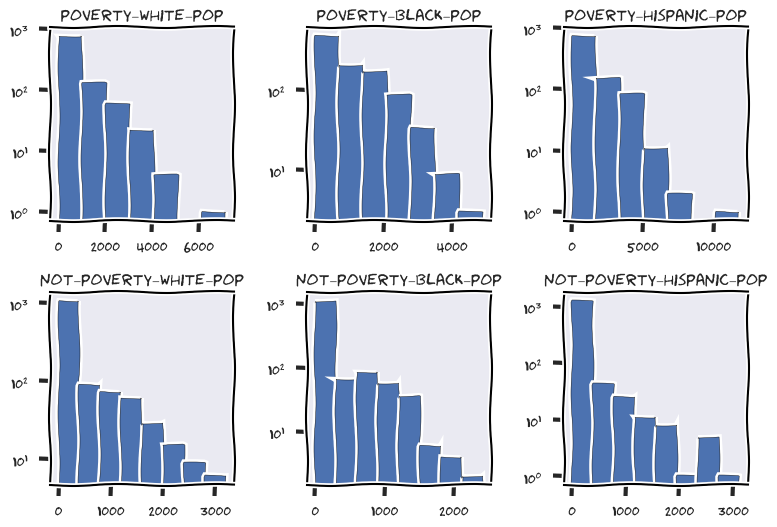

In [36]:
bayes_df = df.select(['poverty', 'white_pop', 'black_pop', 'hispanic_pop'])

poverty_mean = df.select(['poverty']) \
                 .rdd \
                 .map(lambda row: list(row.asDict().values())[0]) \
                 .mean()

# creating a new column with "withColumn"
bayes_df = bayes_df.withColumn("poverty", bayes_df['poverty'] > poverty_mean)



true_poverty, not_true_poverty = [], []

for col in ['white_pop','black_pop', 'hispanic_pop']:

  poverty_samples = bayes_df.filter('poverty IS TRUE') \
                            .select(col) \
                            .rdd \
                            .map(lambda row: list(row.asDict().values())[0]) \
                            .collect()
  true_poverty.append((col, poverty_samples))

  no_poverty_samples = bayes_df.filter('poverty IS NOT TRUE') \
                               .select(col) \
                               .rdd \
                               .map(lambda row: list(row.asDict().values())[0]) \
                               .collect()
  not_true_poverty.append((col, no_poverty_samples))



plt.rcdefaults()
plt.style.use('seaborn')
plt.xkcd()

fig, ax = plt.subplots(nrows=2, ncols=3)

_ = 0
for elem in true_poverty:
  ax[0][_].hist(elem[1], bins=int(1 + np.log(len(elem[1]))), edgecolor='black', log=True)
  ax[0][_].set_title("poverty_" + elem[0])
  _ += 1

_ = 0
for elem in not_true_poverty:
  ax[1][_].hist(elem[1], bins=int(1 + np.log(len(elem[1]))), edgecolor='black', log=True)
  ax[1][_].set_title("not_poverty_" + elem[0])
  _ += 1

plt.tight_layout()
plt.show()

In [37]:
"""
  Obtaining the mean and variance for each column of the dataset
"""
vector_rdd = df.rdd.map(lambda row: list(row.asDict().values()))

summary = Statistics.colStats(vector_rdd)

means = [float(mean) for mean in summary.mean()]
variances = [float(variance) for variance in summary.variance()]

rows = [Row(**dict(zip(df.columns, means))), 
        Row(**dict(zip(df.columns, variances)))]

mean_variance_rdd = sc.parallelize(rows)

schema = StructType([StructField(col, DoubleType()) 
                     for col in df.columns])

mean_variance_df = sql_context.createDataFrame(data=mean_variance_rdd, schema=schema)

mean_variance_df.show()

+------------------+------------------+-----------------+-------------+-----------------+----------+------------------+-----------------------------+------------------+-----------------+---------+------------------+-----------------+---------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------

In [38]:
""" 
  Counting the nans of each column of the dataset
"""
df_agg = df.agg(*[F.count(F.when(F.isnull(column), column)).alias(column) 
                  for column in df.columns])

df_agg.show()

+---------+--------+----------+-------------+-----------------+----------+-------+-----------------------------+---------+---------+---------+------------+--------------+---------------------+--------------+--------------+-------------+---------------+---------------+---------------+---------+---------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+------------+-----------+-------------+-------------+-------------+-------+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----------+----------+-------------+-------------+-------------+-------------+-------------+----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-

In [39]:
""" 
  Again counting the nans of each column of the dataset,
  but this time, it's done with HiveQL on the survey table that I built
  at the begninning of the project
"""
for column in df.columns:
  nans = sql_context.sql(f"SELECT COUNT('a') AS {column} FROM survey WHERE {column} IS NULL").collect()
  print(nans)

[Row(total_pop=0)]
[Row(male_pop=0)]
[Row(female_pop=0)]
[Row(median_income=787)]
[Row(income_per_capita=724)]
[Row(gini_index=788)]
[Row(poverty=0)]
[Row(pop_determined_poverty_status=0)]
[Row(white_pop=0)]
[Row(black_pop=0)]
[Row(asian_pop=0)]
[Row(hispanic_pop=0)]
[Row(amerindian_pop=0)]
[Row(two_or_more_races_pop=0)]
[Row(other_race_pop=0)]
[Row(female_under_5=0)]
[Row(female_5_to_9=0)]
[Row(female_10_to_14=0)]
[Row(female_15_to_17=0)]
[Row(female_18_to_19=0)]
[Row(female_20=0)]
[Row(female_21=0)]
[Row(female_22_to_24=0)]
[Row(female_25_to_29=0)]
[Row(female_30_to_34=0)]
[Row(female_35_to_39=0)]
[Row(female_40_to_44=0)]
[Row(female_45_to_49=0)]
[Row(female_50_to_54=0)]
[Row(female_55_to_59=0)]
[Row(female_60_to_61=0)]
[Row(female_62_to_64=0)]
[Row(female_65_to_66=0)]
[Row(female_67_to_69=0)]
[Row(female_70_to_74=0)]
[Row(female_75_to_79=0)]
[Row(female_80_to_84=0)]
[Row(female_85_and_over=0)]
[Row(male_under_5=0)]
[Row(male_5_to_9=0)]
[Row(male_10_to_14=0)]
[Row(male_15_to_17=0)]
[

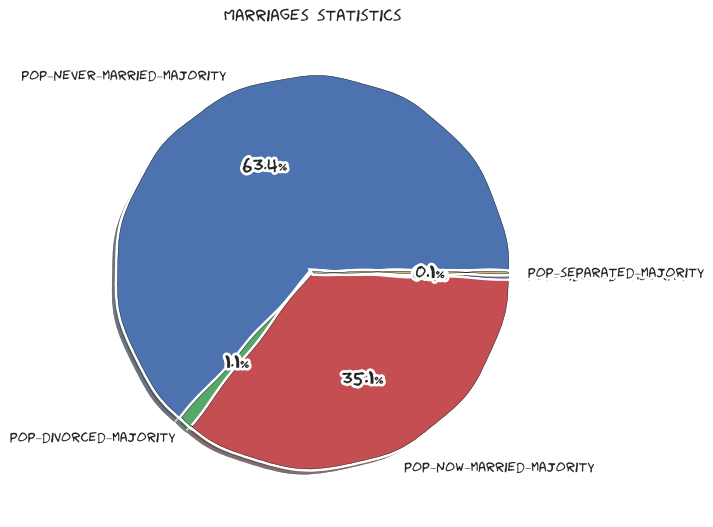

In [40]:
"""
  Pie char with the majority marriage distribution across the U.S.A zones
"""

marriages_dict = {0: 'pop_never_married_majority', 1: 'pop_now_married_majority', 2: 'pop_separated_majority', 3: 'pop_widowed_majority', 4: 'pop_divorced_majority'}

marriages_stats = df.filter("pop_never_married > 0 OR pop_now_married > 0 OR pop_separated > 0 OR pop_widowed > 0 OR pop_divorced > 0") \
                    .select(['pop_never_married', 'pop_now_married', 'pop_separated', 'pop_widowed', 'pop_divorced']) \
                    .rdd.map(lambda row: (marriages_dict[np.argmax(list(row.asDict().values()))] ,1)) \
                    .reduceByKey(lambda value_1, value_2: value_1 + value_2) \
                    .collect()

marriages_stats = dict(marriages_stats)
plt.rcdefaults()
plt.style.use('seaborn')
plt.xkcd()

plt.pie(marriages_stats.values(), labels=marriages_stats.keys(), autopct='%1.1f%%', wedgeprops={"edgecolor": "black"}, shadow=True)

plt.title("Marriages statistics")
plt.tight_layout()
plt.show()

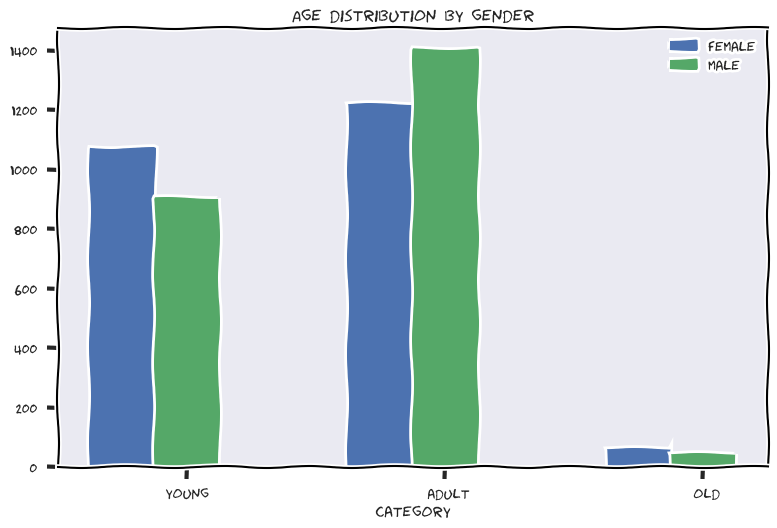

In [41]:
"""
  Bar chart with the majority age distribution across the U.S.A zones
"""

female_categories = {0: 'young_females', 1: 'adult_females', 2: 'old_females'}

female_counts = df.select((df['female_under_5'] + df['female_5_to_9'] + df['female_10_to_14'] + df['female_15_to_17'] + df['female_18_to_19'] + df['female_20'] + df['female_21'] + df['female_22_to_24']).alias('young_females'),
                          (df['female_25_to_29'] + df['female_30_to_34'] + df['female_35_to_39'] + df['female_40_to_44'] + df['female_45_to_49'] + df['female_50_to_54'] + df['female_55_to_59']).alias('adult_females'),
                          (df['female_60_to_61'] + df['female_62_to_64'] + df['female_65_to_66'] + df['female_67_to_69'] + df['female_70_to_74'] + df['female_75_to_79'] + df['female_80_to_84'] + df['female_85_and_over']).alias('old_females')) \
                          .rdd.map(lambda row: (female_categories[np.argmax(list(row.asDict().values()))] ,1)) \
                          .reduceByKey(lambda value_1, value_2: value_1 + value_2) \
                          .collect()

male_categories = {0: 'young_males', 1: 'adult_males', 2: 'old_males'}

male_counts = df.select((df['male_under_5'] + df['male_5_to_9'] + df['male_10_to_14'] + df['male_15_to_17'] + df['male_18_to_19'] + df['male_20'] + df['male_21'] + df['male_22_to_24']).alias('young_males'),
                        (df['male_25_to_29'] + df['male_30_to_34'] + df['male_35_to_39'] + df['male_40_to_44'] + df['male_45_to_49'] + df['male_50_to_54'] + df['male_55_to_59']).alias('adult_males'),
                        (df['male_60_61'] + df['male_62_64'] + df['male_65_to_66'] + df['male_67_to_69'] + df['male_70_to_74'] + df['male_75_to_79'] + df['male_80_to_84'] + df['male_85_and_over']).alias('old_males')) \
                        .rdd.map(lambda row: (male_categories[np.argmax(list(row.asDict().values()))] ,1)) \
                        .reduceByKey(lambda value_1, value_2: value_1 + value_2) \
                        .collect()
                        
female_counts = dict(female_counts).values()
male_counts = dict(male_counts).values()

plt.rcdefaults()
plt.style.use('seaborn')
plt.xkcd()

x_indexes = np.arange(3)
width = 0.25

plt.bar(x_indexes - width, female_counts, width=width, label='female')
plt.bar(x_indexes, male_counts, width=width, label='male')

plt.title("Age distribution by gender")
plt.legend()

plt.xlabel("category")
plt.xticks(ticks=x_indexes, labels=['young',' adult',' old'])

plt.tight_layout()
plt.show()

In [42]:
"""
  Preparing the data for a Chi-Square test of independence.
  Since the columns I try to work with are all numerical continous columns,
  I need to categorize them since Chi-Square works with categorical variables
"""

def decide_income_majority(low, medium, high):

  if medium >= low and medium >= high:
    return "medium_income"

  if high >= low and high >= medium:
    return 'high_income'
  
  if low >= medium and low >= high:
    return "low_income"


schema = StructType([StructField(col, StringType()) 
                     for col in ['gender_majority', 'income_majority']])

gender_income_rdd = df.filter('female_pop!=0 and male_pop!=0') \
                      .select(df['male_pop'], df['female_pop'], \
                              (df['income_less_10000'] + df['income_10000_14999'] + df['income_15000_19999'] + df['income_20000_24999'] + df['income_25000_29999']).alias('low_income'), \
                              (df['income_30000_34999'] + df['income_35000_39999'] + df['income_40000_44999'] + df['income_45000_49999'] + df['income_50000_59999']).alias('medium_income'), \
                              (df['income_60000_74999'] + df['income_75000_99999'] + df['income_100000_124999'] + df['income_125000_149999'] + df['income_150000_199999'] + df['income_200000_or_more']).alias('high_income')) \
                      .rdd \
                      .map(lambda row: list(row.asDict().values())) \
                      .map(lambda vec: [('gender_majority', 'male' if vec[0] > vec[1] else 'female'), ('income_majority', decide_income_majority(vec[2], vec[3], vec[4]))]) \
                      .map(lambda vec: Row(**dict(vec)))

gender_income_df = sql_context.createDataFrame(gender_income_rdd, schema)

gender_income_df.registerTempTable("gender_income_chi")

print("The variables on which I do my Chi-Square test on:")

gender_income_df.show(5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


The variables on which I do my Chi-Square test on:
+---------------+---------------+
|gender_majority|income_majority|
+---------------+---------------+
|           male|  medium_income|
|         female|     low_income|
|         female|     low_income|
|         female|     low_income|
|         female|    high_income|
+---------------+---------------+
only showing top 5 rows



In [43]:
"""
  Preparing the contingency table and the Chi-Square test
"""
from pyspark.mllib.stat import Statistics

contingency_table = gender_income_df.crosstab('gender_majority', 'income_majority')

contingency_table.show()

contingency_table = contingency_table.rdd.map(lambda row: list(row.asDict().values())[1:]).take(2)

independenceTestResult = Statistics.chiSqTest(contingency_table)

print(independenceTestResult)

+-------------------------------+-----------+----------+-------------+
|gender_majority_income_majority|high_income|low_income|medium_income|
+-------------------------------+-----------+----------+-------------+
|                         female|         52|       883|           67|
|                           male|         59|       472|           96|
+-------------------------------+-----------+----------+-------------+

Chi squared test summary:
method: pearson
degrees of freedom = 5 
statistic = 2136.609576427256 
pValue = 0.0 
Very strong presumption against null hypothesis: observed follows the same distribution as expected..


In [44]:
"""
  Now, I want to see some correlations between the variables 
"""
columns_for_regression = ['total_pop','male_pop', 'female_pop'] + race_distribution + education + \
                         ["unemployed_pop", "not_in_labor_force", "pop_in_labor_force"] + \
                         unions + ['poverty', 'pop_determined_poverty_status'] + \
                         ['median_income', 'income_per_capita', 'gini_index']

df_for_regression = df.filter("median_income IS NOT NULL AND income_per_capita IS NOT NULL AND gini_index IS NOT NULL") \
                      \
                      .select(columns_for_regression) \
                      \
                      .withColumn('college_dropouts', df['less_one_year_college'] + df['one_year_more_college']) \
                      \
                      .drop('less_one_year_college', 'one_year_more_college')



# Make it RDD[Vector] so that it can be accepted by StandardScaler

rdd_for_regression = df_for_regression.rdd.map(lambda row: list(row.asDict().values()))

scaled_rdd_for_regression = StandardScaler().fit(rdd_for_regression).transform(rdd_for_regression)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


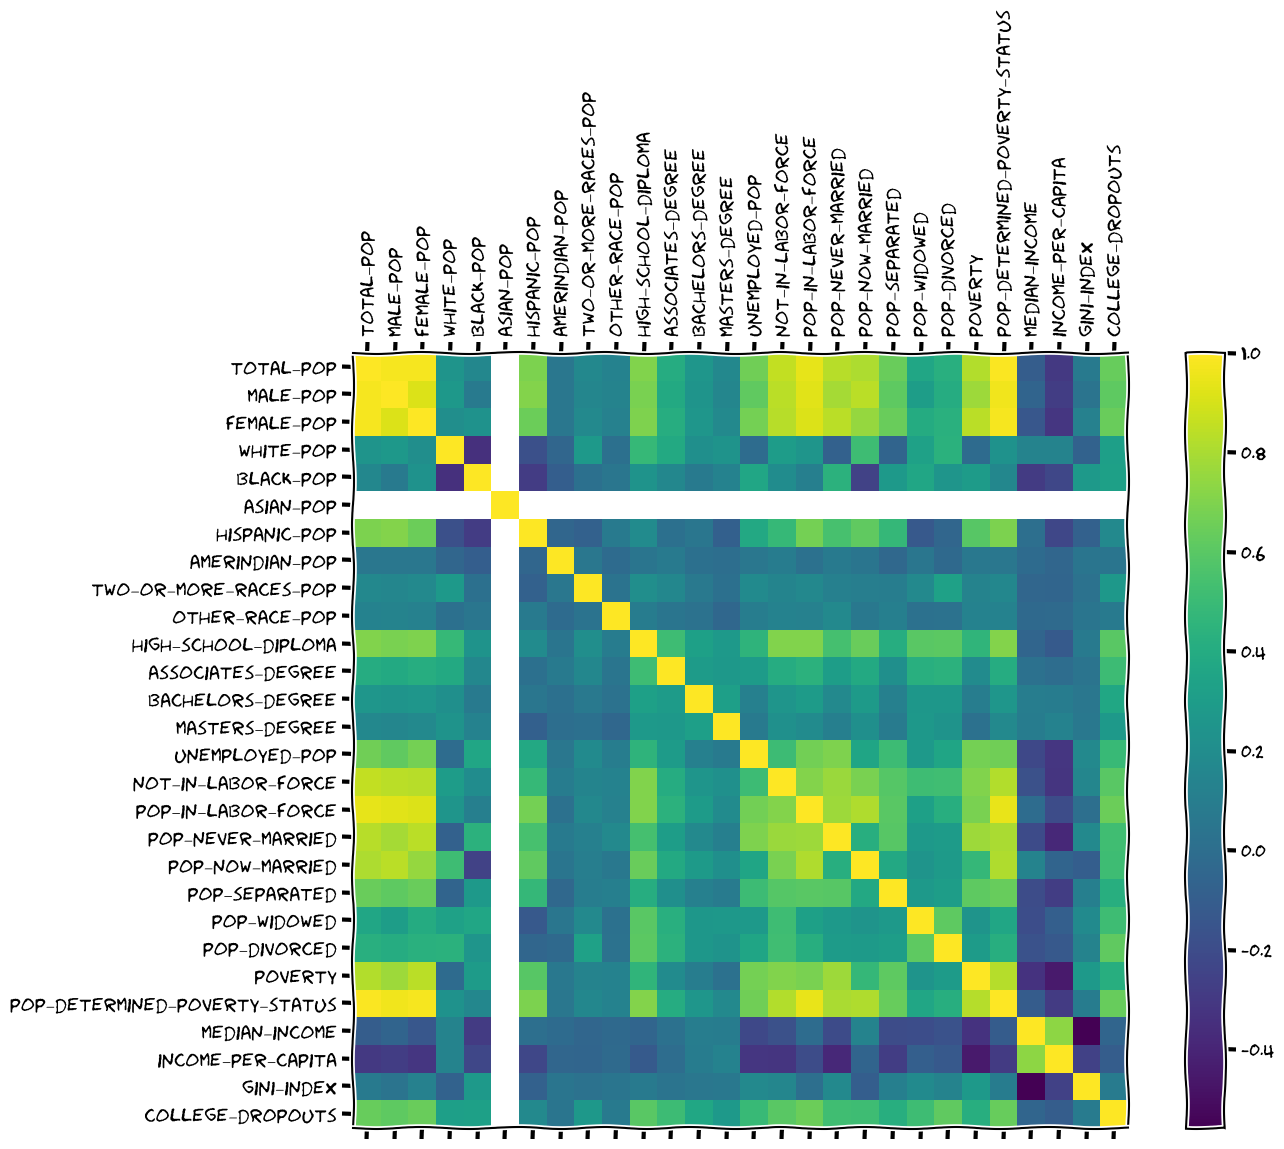

In [45]:
corr_matrix = Statistics.corr(scaled_rdd_for_regression, method='pearson')

plt.rcdefaults()
plt.xkcd()

f = plt.figure(figsize=(15, 10))

plt.matshow(corr_matrix, fignum=f.number)

plt.xticks(ticks=range(0, corr_matrix.shape[0]), labels=df_for_regression.columns, rotation=90)
plt.yticks(ticks=range(0, corr_matrix.shape[0]), labels=df_for_regression.columns)

plt.colorbar()

plt.tight_layout()
plt.show()

In [46]:
for col in [(-2, 'gini_index'), (-3, 'income_per_capita'), (-4, 'median_income')]:

  good_correlations = list(filter(lambda elem: abs(elem[1]) > 0.4 , 
                                  list(zip(df_for_regression.columns, corr_matrix[col[0]]))))
  
  print(f"Good correlations between '{col[1]}' and {good_correlations}")

Good correlations between 'gini_index' and [('median_income', -0.5577260162865385), ('gini_index', 1.0)]
Good correlations between 'income_per_capita' and [('poverty', -0.4478742147141697), ('median_income', 0.73230924710714), ('income_per_capita', 1.0)]
Good correlations between 'median_income' and [('median_income', 1.0), ('income_per_capita', 0.73230924710714), ('gini_index', -0.5577260162865385)]


In [47]:
"""
  Linear Regression between poverty and income_per_capita to predict income_per_capita
  median_income nans and gini_index nans will be replaced by the mean
"""

means = list()

for column in ['median_income', 'gini_index']:

  means.append(df.select(column) \
                 .filter(f'{column} IS NOT NULL') \
                 .rdd \
                 .map(lambda row: list(row.asDict().values())[0]) \
                 .mean())

replaced_nans_rdd = df.rdd.map(lambda row: Row(**dict([(elem[0], means[0]) if elem[1] is None and elem[0] == 'median_income' else 
                                                       (elem[0], means[1]) if elem[1] is None and elem[0] == 'gini_index' else 
                                                       elem
                                                       for elem in list(row.asDict().items())]))
                              )


df = sql_context.createDataFrame(replaced_nans_rdd)

df.show(5)

+---------+--------+----------+-----------------+-----------------+-------------------+-------+-----------------------------+---------+---------+---------+------------+--------------+---------------------+--------------+--------------+-------------+---------------+---------------+---------------+---------+---------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+------------+-----------+-------------+-------------+-------------+-------+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----------+----------+-------------+-------------+-------------+-------------+-------------+----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------

In [48]:
# StandardScaler().fit().transform() spits a RDD[Vector], hence get it back to DF format

columns_for_regression = df_for_regression.columns
scaled_rdd_for_regression = scaled_rdd_for_regression.map(lambda vec: [float(elem) for elem in vec]) \
                                                     .map(lambda vec: Row(**dict(zip(columns_for_regression, vec))))


schema = StructType([StructField(col, FloatType()) 
                     for col in columns_for_regression])

scaled_df_for_regression = sql_context.createDataFrame(scaled_rdd_for_regression, schema)

#-------------------------------------------------------------------------------

def get_df_with_vector_assembler(df: pyspark.sql.dataframe.DataFrame,
                                 input_cols: list, 
                                 feature_column_name: str,
                                 all_cols_for_regression: list) -> pyspark.sql.dataframe.DataFrame:
  
  return VectorAssembler(inputCols=input_cols, outputCol=feature_column_name).transform(df.select(all_cols_for_regression)) \
                                                                             .drop(*input_cols)

df_1 = get_df_with_vector_assembler(df=scaled_df_for_regression, 
                                    input_cols=['poverty'],
                                    feature_column_name='poverty_',
                                    all_cols_for_regression=['poverty', 'income_per_capita'])

train_df_1, test_df_1 = df_1.randomSplit([0.9, 0.1])

train_df_1.show(5)

+-----------------+--------------------+
|income_per_capita|            poverty_|
+-----------------+--------------------+
|       0.21015117|               [0.0]|
|        0.2288405|[0.2350267618894577]|
|       0.27120298|               [0.0]|
|       0.28158596|[0.01521755941212...|
|       0.31702647|[4.3674397468566895]|
+-----------------+--------------------+
only showing top 5 rows



In [49]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression


# ------------------------------------------ FIT --------------------------------------------------------------------------------
# # https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.regression.LinearRegressionSummary.html

linear_regression_1 = LinearRegression(featuresCol='poverty_', labelCol='income_per_capita', standardization=False, elasticNetParam=1, regParam=0.1) # L2 regularization
fitted_lr_1 = linear_regression_1.fit(train_df_1) # returns LinearRegressionModel

# ------------------------------------------ PREDICT --------------------------------------------------------------------------------

lr_1_summary = fitted_lr_1.evaluate(test_df_1) # returns LinearRegressionSummary
lr_1_summary.predictions.show(5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-----------------+--------------------+------------------+
|income_per_capita|            poverty_|        prediction|
+-----------------+--------------------+------------------+
|        0.5987509|[3.0367486476898193]|1.3412627422517427|
|        0.8313292|[0.8504924774169922]| 2.097935215058847|
|        0.8714767| [4.313332557678223]|0.8994316718350754|
|        1.0345584| [5.008267879486084]|0.6589116286931345|
|        1.0508943|[1.0009772777557373]| 2.045851791560496|
+-----------------+--------------------+------------------+
only showing top 5 rows



In [50]:
evaluator_1 = RegressionEvaluator(labelCol='income_per_capita', predictionCol='prediction')

print(f"R2 coefficient for the first model is: {evaluator_1.evaluate(lr_1_summary.predictions, {evaluator_1.metricName: 'r2'})}")

print(f"Coeffiecients and intercept for the first LR (poverty, income_per_capita) model: {fitted_lr_1.coefficients}, {fitted_lr_1.intercept}")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


R2 coefficient for the first model is: 0.23152687912638725
Coeffiecients and intercept for the first LR (poverty, income_per_capita) model: [-0.34610421372198], 2.3922942452317137


In [51]:
"""
  The path argument of the 'hadoopFile' function accepts a file or a directory of files etc.
"""


"""
  With "TextInputFormat" -> the input is \n terminated lines
                            *Note: each line corresponds to an RDD row
"""
text_input_format_rdd = sc.hadoopFile(path="/content/sample_data/test_file.txt", 
                                      inputFormatClass="org.apache.hadoop.mapred.TextInputFormat", 
                                      keyClass="org.apache.hadoop.io.LongWritable", 
                                      valueClass="org.apache.hadoop.io.Text")


"""
  With "KeyValueTextInputFormat" -> the input is \n terminated lines of the form 
                                   ---key [separator] value---
                                   *Note: By default, the separator is a tab
"""
key_value_text_input_format_rdd = sc.hadoopFile(path=r"/content/sample_data/key_value_text_input_format.txt", 
                                                inputFormatClass="org.apache.hadoop.mapred.KeyValueTextInputFormat", 
                                                keyClass="org.apache.hadoop.io.LongWritable",
                                                valueClass="org.apache.hadoop.io.Text")


"""
  With "wholeTextFiles" -> you either provide a single file as input,
                        -> or a directory of files as input
                        *Note: creates a PairRDD where each row is a (key, value) pair;
                               the key is a file path
                               the value is the content of that file
"""
single_json = sc.wholeTextFiles(path="/content/sample_data/json_1.txt")

multiple_files_rdd = sc.wholeTextFiles(path="/content/sample_data/directory_of_files")


Py4JJavaError: ignored